In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd

from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer, LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve, classification_report
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold
from sklearn.decomposition import TruncatedSVD 
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import xgboost as xgb

from sklearn.model_selection import train_test_split
import seaborn as sns

In [2]:
train = pd.read_csv('C:/datasets/flight-delays-fall-2018/flight_delays_train.csv.zip')
test = pd.read_csv('C:/datasets/flight-delays-fall-2018/flight_delays_test.csv.zip')
sample_submission = pd.read_csv('C:/datasets/flight-delays-fall-2018/sample_submission.csv.zip')

In [3]:
label_bin = LabelBinarizer()
train['dep_delayed_15min'] = label_bin.fit_transform(train['dep_delayed_15min'])

In [4]:
train['Flight'] = train['Origin'] + '-' + train['Dest']
test['Flight'] = test['Origin'] + '-' + test['Dest']

In [5]:
train['season'] = train['Month'].copy()
test['season'] = test['Month'].copy()

In [6]:
train['season'] = train['season'].replace(['c-12','c-1','c-2'],'winter')
train['season'] = train['season'].replace(['c-3','c-4','c-5'],'spring')
train['season'] = train['season'].replace(['c-6','c-7','c-8'],'summer')
train['season'] = train['season'].replace(['c-9','c-10','c-11'],'autumn')
test['season'] = test['season'].replace(['c-12','c-1','c-2'],'winter')
test['season'] = test['season'].replace(['c-3','c-4','c-5'],'spring')
test['season'] = test['season'].replace(['c-6','c-7','c-8'],'summer')
test['season'] = test['season'].replace(['c-9','c-10','c-11'],'autumn')

<AxesSubplot:xlabel='DepTime', ylabel='Density'>

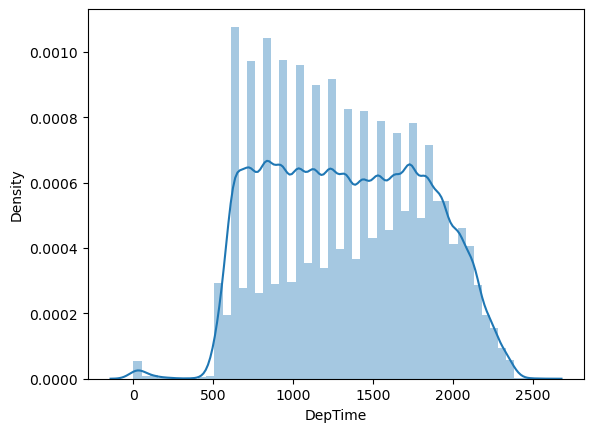

In [7]:
sns.distplot(train['DepTime'])

<AxesSubplot:xlabel='Distance', ylabel='Density'>

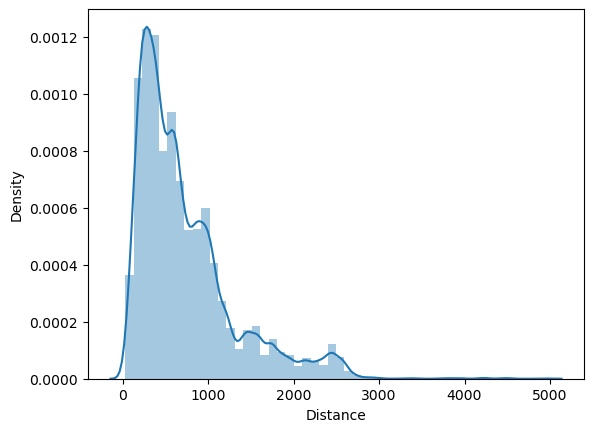

In [8]:
sns.distplot(train['Distance'])

In [9]:
train['daytime'] = 0
train['daytime'] = train['daytime'].astype('int64')

values = train.query("DepTime >= 2400 & DepTime <= 2534")['DepTime'].unique().tolist()
indexes = train.query("DepTime >= 2400 & DepTime <= 2534")['DepTime'].index.tolist()
train.loc[indexes,'daytime'] = train.loc[indexes,'DepTime'].replace(values,'night')

values = train.query("DepTime > 2400 & DepTime < 2534")['DepTime'].unique().tolist()
indexes = train.query("DepTime > 2400 & DepTime < 2534")['DepTime'].index.tolist()
train.loc[indexes,'daytime'] = train.loc[indexes,'DepTime'].replace(values,'night')

values = train.query("DepTime >= 1 & DepTime < 600")['DepTime'].unique().tolist()
indexes = train.query("DepTime >= 1 & DepTime < 600")['DepTime'].index.tolist()
train.loc[indexes,'daytime'] = train.loc[indexes,'DepTime'].replace(values,'night')

values = train.query("DepTime >= 600 & DepTime < 1200")['DepTime'].unique().tolist()
indexes = train.query("DepTime >= 600 & DepTime < 1200")['DepTime'].index.tolist()
train.loc[indexes,'daytime'] = train.loc[indexes,'DepTime'].replace(values,'morning')

values = train.query("DepTime >= 1200 & DepTime < 1800")['DepTime'].unique().tolist()
indexes = train.query("DepTime >= 1200 & DepTime < 1800")['DepTime'].index.tolist()
train.loc[indexes,'daytime'] = train.loc[indexes,'DepTime'].replace(values,'day')

values = train.query("DepTime >= 1800 & DepTime < 2400")['DepTime'].unique().tolist()
indexes = train.query("DepTime >= 1800 & DepTime < 2400")['DepTime'].index.tolist()
train.loc[indexes,'daytime'] = train.loc[indexes,'DepTime'].replace(values,'evening')

In [10]:
test['daytime'] = 0
test['daytime'] = test['daytime'].astype('int64')

values = test.query("DepTime >= 2400 & DepTime <= 2534")['DepTime'].unique().tolist()
indexes = test.query("DepTime >= 2400 & DepTime <= 2534")['DepTime'].index.tolist()
test.loc[indexes,'daytime'] = test.loc[indexes,'DepTime'].replace(values,'night')

values = test.query("DepTime > 2400 & DepTime < 2534")['DepTime'].unique().tolist()
indexes = test.query("DepTime > 2400 & DepTime < 2534")['DepTime'].index.tolist()
test.loc[indexes,'daytime'] = test.loc[indexes,'DepTime'].replace(values,'night')

values = test.query("DepTime >= 1 & DepTime < 600")['DepTime'].unique().tolist()
indexes = test.query("DepTime >= 1 & DepTime < 600")['DepTime'].index.tolist()
test.loc[indexes,'daytime'] = test.loc[indexes,'DepTime'].replace(values,'night')

values = test.query("DepTime >= 600 & DepTime < 1200")['DepTime'].unique().tolist()
indexes = test.query("DepTime >= 600 & DepTime < 1200")['DepTime'].index.tolist()
test.loc[indexes,'daytime'] = test.loc[indexes,'DepTime'].replace(values,'morning')

values = test.query("DepTime >= 1200 & DepTime < 1800")['DepTime'].unique().tolist()
indexes = test.query("DepTime >= 1200 & DepTime < 1800")['DepTime'].index.tolist()
test.loc[indexes,'daytime'] = test.loc[indexes,'DepTime'].replace(values,'day')

values = test.query("DepTime >= 1800 & DepTime < 2400")['DepTime'].unique().tolist()
indexes = test.query("DepTime >= 1800 & DepTime < 2400")['DepTime'].index.tolist()
test.loc[indexes,'daytime'] = test.loc[indexes,'DepTime'].replace(values,'evening')

In [11]:
train['daytime'].value_counts()

morning    38376
day        37391
evening    22111
night       2122
Name: daytime, dtype: int64

In [12]:
test['daytime'].value_counts()

morning    38482
day        36935
evening    22186
night       2397
Name: daytime, dtype: int64

In [13]:
temp = pd.get_dummies(train[['daytime', 'season']])
train = pd.concat((train.drop(['daytime', 'season'],axis=1), temp), axis=1)

temp = pd.get_dummies(test[['daytime', 'season']])
test = pd.concat((test.drop(['daytime', 'season'],axis=1), temp), axis=1)

In [14]:
train.corr()

,DepTime,Distance,dep_delayed_15min,daytime_day,daytime_evening,daytime_morning,daytime_night,season_autumn,season_spring,season_summer,season_winter
DepTime,1.000000,-0.020681,0.243819,0.226035,0.725855,-0.764909,-0.267944,-0.006620,-0.001028,0.006526,0.001044
Distance,-0.020681,1.000000,-0.002734,-0.021293,-0.009394,0.029625,-0.001429,-0.003864,-0.004950,0.006655,0.002136
dep_delayed_15min,0.243819,-0.002734,1.000000,0.038492,0.194246,-0.196985,-0.023877,-0.031611,-0.033285,0.045380,0.019420
daytime_day,0.226035,-0.021293,0.038492,1.000000,-0.411748,-0.609846,-0.113788,-0.000085,0.000668,-0.003723,0.003236
daytime_evening,0.725855,-0.009394,0.194246,-0.411748,1.000000,-0.420456,-0.078451,-0.007069,0.000581,0.007981,-0.001649
daytime_morning,-0.764909,0.029625,-0.196985,-0.609846,-0.420456,1.000000,-0.116194,0.007361,-0.000025,-0.005328,-0.001951
daytime_night,-0.267944,-0.001429,-0.023877,-0.113788,-0.078451,-0.116194,1.000000,-0.004198,-0.003832,0.007494,0.000466
season_autumn,-0.006620,-0.003864,-0.031611,-0.000085,-0.007069,0.007361,-0.004198,1.000000,-0.335896,-0.339464,-0.320107
season_spring,-0.001028,-0.004950,-0.033285,0.000668,0.000581,-0.000025,-0.003832,-0.335896,1.000000,-0.346756,-0.326983
season_summer,0.006526,0.006655,0.045380,-0.003723,0.007981,-0.005328,0.007494,-0.339464,-0.346756,1.000000,-0.330456


In [15]:
in_train = list(set(train['UniqueCarrier'].unique()) - set(test['UniqueCarrier'].unique())); in_train

in_test = list(set(test['UniqueCarrier'].unique()) - set(train['UniqueCarrier'].unique())); in_test

train_carrier_dummied = pd.get_dummies(train['UniqueCarrier']).drop(in_train, axis=1)
test_carrier_dummied = pd.get_dummies(test['UniqueCarrier']).drop(in_test, axis=1)

n_components = 2
decompose = TruncatedSVD(n_components=n_components)

decompose.fit(train_carrier_dummied) 

train_carrier_transformed = decompose.transform(train_carrier_dummied)

test_carrier_transformed = decompose.transform(test_carrier_dummied)

train_carrier_transformed = pd.DataFrame(train_carrier_transformed)
for i in range(train_carrier_transformed.shape[1]):
    train_carrier_transformed = train_carrier_transformed.rename(columns={i:f'UniqueCarrier_decomposed_x{i+1}'})
    
test_carrier_transformed = pd.DataFrame(test_carrier_transformed)
for i in range(test_carrier_transformed.shape[1]):
    test_carrier_transformed = test_carrier_transformed.rename(columns={i:f'UniqueCarrier_decomposed_x{i+1}'})

train = pd.concat((train.drop(['UniqueCarrier'], axis=1), train_carrier_transformed), axis=1)
test = pd.concat((test.drop(['UniqueCarrier'], axis=1), test_carrier_transformed), axis=1)

In [16]:
in_train = list(set(train['Origin'].unique()) - set(test['Origin'].unique())); in_train

in_test = list(set(test['Origin'].unique()) - set(train['Origin'].unique())); in_test

train_carrier_dummied = pd.get_dummies(train['Origin']).drop(in_train, axis=1)
test_carrier_dummied = pd.get_dummies(test['Origin']).drop(in_test, axis=1)

n_components = 2
decompose = TruncatedSVD(n_components=n_components)

decompose.fit(train_carrier_dummied) 

train_carrier_transformed = decompose.transform(train_carrier_dummied)

test_carrier_transformed = decompose.transform(test_carrier_dummied)

train_carrier_transformed = pd.DataFrame(train_carrier_transformed)
for i in range(train_carrier_transformed.shape[1]):
    train_carrier_transformed = train_carrier_transformed.rename(columns={i:f'Origin_decomposed_x{i+1}'})
    
test_carrier_transformed = pd.DataFrame(test_carrier_transformed)
for i in range(test_carrier_transformed.shape[1]):
    test_carrier_transformed = test_carrier_transformed.rename(columns={i:f'Origin_decomposed_x{i+1}'})

train = pd.concat((train.drop(['Origin'], axis=1), train_carrier_transformed), axis=1)
test = pd.concat((test.drop(['Origin'], axis=1), test_carrier_transformed), axis=1)

In [17]:
in_train = list(set(train['Dest'].unique()) - set(test['Dest'].unique())); in_train

in_test = list(set(test['Dest'].unique()) - set(train['Dest'].unique())); in_test

train_carrier_dummied = pd.get_dummies(train['Dest']).drop(in_train, axis=1)
test_carrier_dummied = pd.get_dummies(test['Dest']).drop(in_test, axis=1)

n_components = 2
decompose = TruncatedSVD(n_components=n_components)

decompose.fit(train_carrier_dummied) 

train_carrier_transformed = decompose.transform(train_carrier_dummied)

test_carrier_transformed = decompose.transform(test_carrier_dummied)

train_carrier_transformed = pd.DataFrame(train_carrier_transformed)
for i in range(train_carrier_transformed.shape[1]):
    train_carrier_transformed = train_carrier_transformed.rename(columns={i:f'Dest_decomposed_x{i+1}'})
    
test_carrier_transformed = pd.DataFrame(test_carrier_transformed)
for i in range(test_carrier_transformed.shape[1]):
    test_carrier_transformed = test_carrier_transformed.rename(columns={i:f'Dest_decomposed_x{i+1}'})

train = pd.concat((train.drop(['Dest'], axis=1), train_carrier_transformed), axis=1)
test = pd.concat((test.drop(['Dest'], axis=1), test_carrier_transformed), axis=1)

In [18]:
in_train = list(set(train['Flight'].unique()) - set(test['Flight'].unique())); in_train

in_test = list(set(test['Flight'].unique()) - set(train['Flight'].unique())); in_test

train_carrier_dummied = pd.get_dummies(train['Flight']).drop(in_train, axis=1)
test_carrier_dummied = pd.get_dummies(test['Flight']).drop(in_test, axis=1)

n_components = 2
decompose = TruncatedSVD(n_components=n_components)

decompose.fit(train_carrier_dummied) 

train_carrier_transformed = decompose.transform(train_carrier_dummied)

test_carrier_transformed = decompose.transform(test_carrier_dummied)

train_carrier_transformed = pd.DataFrame(train_carrier_transformed)
for i in range(train_carrier_transformed.shape[1]):
    train_carrier_transformed = train_carrier_transformed.rename(columns={i:f'Flight_decomposed_x{i+1}'})
    
test_carrier_transformed = pd.DataFrame(test_carrier_transformed)
for i in range(test_carrier_transformed.shape[1]):
    test_carrier_transformed = test_carrier_transformed.rename(columns={i:f'Flight_decomposed_x{i+1}'})

train = pd.concat((train.drop(['Flight'], axis=1), train_carrier_transformed), axis=1)
test = pd.concat((test.drop(['Flight'], axis=1), test_carrier_transformed), axis=1)

In [19]:
temp = pd.get_dummies(train[['Month','DayofMonth','DayOfWeek']])

train = pd.concat((train.drop(['Month','DayofMonth','DayOfWeek'],axis=1), temp), axis=1)

temp = pd.get_dummies(test[['Month','DayofMonth','DayOfWeek']])

test = pd.concat((test.drop(['Month','DayofMonth','DayOfWeek'],axis=1), temp), axis=1)

In [20]:
# for i in range(1,13):
#      train['Month'] = train['Month'].replace(f'c-{i}',i)

# for i in range(1,32):
#      train['DayofMonth'] = train['DayofMonth'].replace(f'c-{i}',i)

# for i in range(1,8):
#      train['DayOfWeek'] = train['DayOfWeek'].replace(f'c-{i}',i)

# for i in range(1,13):
#      test['Month'] = test['Month'].replace(f'c-{i}',i)

# for i in range(1,32):
#      test['DayofMonth'] = test['DayofMonth'].replace(f'c-{i}',i)

# for i in range(1,8):
#      test['DayOfWeek'] = test['DayOfWeek'].replace(f'c-{i}',i)

scaler = StandardScaler()

scaler.fit(train[['DepTime','Distance']])

train[['DepTime','Distance']] = scaler.transform(train[['DepTime','Distance']]) 
test[['DepTime','Distance']] = scaler.transform(test[['DepTime','Distance']])

In [21]:
train.describe()

,DepTime,Distance,dep_delayed_15min,daytime_day,daytime_evening,daytime_morning,daytime_night,season_autumn,season_spring,season_summer,...,DayofMonth_c-7,DayofMonth_c-8,DayofMonth_c-9,DayOfWeek_c-1,DayOfWeek_c-2,DayOfWeek_c-3,DayOfWeek_c-4,DayOfWeek_c-5,DayOfWeek_c-6,DayOfWeek_c-7
count,1.000000e+05,1.000000e+05,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,8.785750e-17,1.083106e-17,0.19044,0.373910,0.221110,0.383760,0.021220,0.247460,0.255460,0.259500,...,0.032720,0.032580,0.032830,0.145690,0.146040,0.145080,0.147360,0.146570,0.128290,0.140970
std,1.000005e+00,1.000005e+00,0.39265,0.483843,0.414996,0.486303,0.144118,0.431538,0.436122,0.438362,...,0.177904,0.177536,0.178192,0.352797,0.353148,0.352183,0.354466,0.353679,0.334414,0.347992
min,-2.814003e+00,-1.217160e+00,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-8.617643e-01,-7.176943e-01,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-2.419072e-02,-2.686972e-01,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,8.217796e-01,3.960969e-01,0.00000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2.503224e+00,7.365993e+00,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [22]:
train.columns

Index(['DepTime', 'Distance', 'dep_delayed_15min', 'daytime_day',
       'daytime_evening', 'daytime_morning', 'daytime_night', 'season_autumn',
       'season_spring', 'season_summer', 'season_winter',
       'UniqueCarrier_decomposed_x1', 'UniqueCarrier_decomposed_x2',
       'Origin_decomposed_x1', 'Origin_decomposed_x2', 'Dest_decomposed_x1',
       'Dest_decomposed_x2', 'Flight_decomposed_x1', 'Flight_decomposed_x2',
       'Month_c-1', 'Month_c-10', 'Month_c-11', 'Month_c-12', 'Month_c-2',
       'Month_c-3', 'Month_c-4', 'Month_c-5', 'Month_c-6', 'Month_c-7',
       'Month_c-8', 'Month_c-9', 'DayofMonth_c-1', 'DayofMonth_c-10',
       'DayofMonth_c-11', 'DayofMonth_c-12', 'DayofMonth_c-13',
       'DayofMonth_c-14', 'DayofMonth_c-15', 'DayofMonth_c-16',
       'DayofMonth_c-17', 'DayofMonth_c-18', 'DayofMonth_c-19',
       'DayofMonth_c-2', 'DayofMonth_c-20', 'DayofMonth_c-21',
       'DayofMonth_c-22', 'DayofMonth_c-23', 'DayofMonth_c-24',
       'DayofMonth_c-25', 'DayofMonth_

In [23]:
set(train.drop('dep_delayed_15min', axis=1).columns) - set(test.columns)

set()

In [24]:
set(test.columns) - set(train.drop('dep_delayed_15min',axis=1).columns)

set()

In [25]:
target = train['dep_delayed_15min']

In [26]:
# training model with Gradient Boosting Algorithm with Cross-Validation
features = train.drop('dep_delayed_15min', axis=1)

kfold = KFold(n_splits=10,random_state=42,shuffle=True) #kfold cross validation, 10-subsets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2,random_state=17)

In [27]:
balanced_train = pd.concat((X_train, y_train), axis=1)

In [28]:
# X_balanced_0, X_balanced_1, y_balanced_0, y_balanced_1 = train_test_split(balanced_train.query("dep_delayed_15min == 0").drop('dep_delayed_15min',axis=1), balanced_train.query("dep_delayed_15min == 0")['dep_delayed_15min'], test_size=0.25, random_state=17)

In [29]:
# balanced_0 = pd.concat((X_balanced_1, y_balanced_1), axis=1)

In [30]:
# balanced_train = pd.concat((balanced_0, balanced_train.query("dep_delayed_15min == 1")), axis=0)

In [31]:
# X_train = balanced_train.drop('dep_delayed_15min', axis=1)
# y_train = balanced_train['dep_delayed_15min']

In [32]:
# balanced_train['dep_delayed_15min'].value_counts()
# y_train.value_counts()
# y_test.value_counts()

In [33]:
xg_clf = xgb.XGBClassifier(gamma=0.3, learning_rate=0.1, max_depth=15, n_estimators=5000, subsample=1, tree_method='gpu_hist')

xg_clf.fit(features, target)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.3, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=15, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=5000,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [35]:
# params = {
# #         'objective': ['binary:logistic'],
# #         'base_score': [0.5],
# #         'booster': ['gbtree'],
# #         'colsample_bylevel': [1],
# #         'colsample_bynode': [1],
# #         'colsample_bytree': [1],
# #         'eval_metric': [None],
#         'gamma': [0,0.2,0.5,0.7,1.0], # gamma is a complexity controller constant that prevents other loosely non-conservative parameters from fitting the trees to noise (overfitting).
# #         'gpu_id': [-1],
# #         'grow_policy': ['depthwise'],
# #         'interaction_constraints': [''],
#         'learning_rate': [0.001,0.01,0.1,0.2,0.3,0.5],
#         'n_estimators' : [700,800,900,1000],
# #         'max_bin': [256],
# #         'max_cat_to_onehot': [4],
# #         'max_delta_step': [0],
#         'max_depth': [8,13,16,20],
# #         'max_leaves': [0],
# #         'min_child_weight': [1],
# #         'monotone_constraints': ['()'],
# #         'num_parallel_tree': [1],
# #         'predictor': ['auto'],
# #         'random_state': [0],
# #         'reg_alpha': [0],
# #         'reg_lambda': [1],
# #         'sampling_method': ['uniform'],
# #         'scale_pos_weight': [1],
#          'subsample': [0.4,0.6,0.8,1], # parameter determines how much of the initial dataset is taken each iteration
#          'tree_method': ['gpu_hist'],
# #         'validate_parameters': [1]
#         }

# xgb_model = xgb.XGBClassifier()

# grid_xgb = RandomizedSearchCV(estimator = xgb_model,param_distributions = params, scoring=scoring, refit=auc_score, verbose=3)
# grid_xgb.fit(X_train, y_train)

<AxesSubplot:xlabel='fpr'>

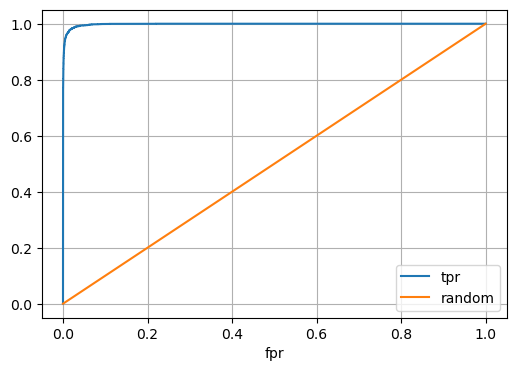

In [37]:
fpr, tpr, thr = roc_curve(y_test, xg_clf.predict_proba(X_test)[:,1])
roc = pd.DataFrame({'fpr':fpr, 'tpr':tpr, 'thr':thr});
roc['random'] = roc['fpr'].copy()
roc['diff'] = roc['tpr'] - roc['fpr']
roc.plot(x='fpr', y=['tpr','random'], figsize=(6,4), grid=True)

In [38]:
roc.sort_values('diff', ascending=False)

,fpr,tpr,thr,random,diff
296,0.017704,0.979942,0.285732,0.017704,0.962238
298,0.018012,0.980206,0.285199,0.018012,0.962193
294,0.017581,0.979678,0.286025,0.017581,0.962097
314,0.020788,0.982845,0.276035,0.020788,0.962057
304,0.018999,0.980998,0.282289,0.018999,0.961998
...,...,...,...,...,...
437,0.601382,1.000000,0.055852,0.601382,0.398618
438,0.601505,1.000000,0.055850,0.601505,0.398495
1,0.000000,0.000264,0.993797,0.000000,0.000264
0,0.000000,0.000000,1.993797,0.000000,0.000000


In [40]:
preds = (xg_clf.predict_proba(X_test)[:,1] >= 0.5).astype('int64')
print(f'accuracy_test: {accuracy_score(y_test, preds)}')
print(f'roc_auc_test: {roc_auc_score(y_test, xg_clf.predict_proba(X_test)[:,1])}')
print(confusion_matrix(y_test, xg_clf.predict(X_test)))
print(classification_report(y_test, preds))

accuracy_test: 0.95375
roc_auc_test: 0.9984746956452922
[[16207     4]
 [  921  2868]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     16211
           1       1.00      0.76      0.86      3789

    accuracy                           0.95     20000
   macro avg       0.97      0.88      0.92     20000
weighted avg       0.96      0.95      0.95     20000



In [41]:
preds = (xg_clf.predict_proba(X_test)[:,1] >= roc.sort_values('diff', ascending=False).loc[296,'thr']).astype('int64')
print(f'accuracy_test: {accuracy_score(y_test, preds)}')
print(f'roc_auc_test: {roc_auc_score(y_test, xg_clf.predict_proba(X_test)[:,1])}')
print(confusion_matrix(y_test, xg_clf.predict(X_test)))
print(classification_report(y_test, preds))

accuracy_test: 0.98185
roc_auc_test: 0.9984746956452922
[[16207     4]
 [  921  2868]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     16211
           1       0.93      0.98      0.95      3789

    accuracy                           0.98     20000
   macro avg       0.96      0.98      0.97     20000
weighted avg       0.98      0.98      0.98     20000



In [ ]:
predictions = ctb.predict_proba(test)[:, 1]

In [ ]:
sample_submission['dep_delayed_15min'] = predictions

sample_submission.to_csv('C:/datasets/flight-delays-fall-2018/submit01.csv', index=False)

pd.read_csv('C:/datasets/flight-delays-fall-2018/submit01.csv')